In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.metrics import classification_report

%matplotlib inline
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = "tight"
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

## Classification Example - MNIST

In [2]:
# mnist = tf.keras.datasets.mnist

In [3]:
(x_train, y_train),(x_test, y_test) = datasets.mnist.load_data()

# rescale the images from [0, 255] to the [0.0, 0.1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


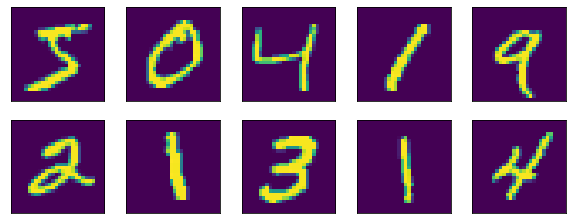

In [4]:
# check the first 10 examples
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
#     plt.xlabel(class_names[train_labels[i][0]])
plt.show()

#### Convolutional Neural Networks

<img src="img/lab_10_cnn.png"/>

A **Convolutional Neural Network** (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.


The architecture of a ConvNet is analogous to that of the connectivity pattern of Neurons in the Human Brain and was inspired by the organization of the Visual Cortex. Individual neurons respond to stimuli only in a restricted region of the visual field known as the Receptive Field. A collection of such fields overlap to cover the entire visual area.

## Image as data
Sofar we've seen that everytime we work with ML models, we need to have the input data as vectors. There’s almost no ML model where vectors aren’t used at some point in the project lifecycle. Machines can’t read text or look at images like you and me. They need input to be transformed or encoded into numbers. 

Please be aware that the a strictly mathematical definition of vectors can fail to convey all the information you need to work with and understand vectors in an ML context like this:

<img src="img/lab_10_img_as_data_.png"/>

so for MNIST data, we turned a (28, 28) image to a vector of size (748,).

An image is nothing but a matrix of pixel values. In last session, we just flattened them in order to train a sequential NN on them.

In [5]:
x_train[0].flatten().shape

(784,)

(28, 28) (784,)


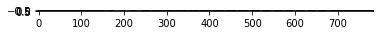

In [6]:
print(x_train[0].shape, x_train[0].flatten().shape)

a = np.expand_dims(x_train[0].flatten(), axis=0)  # or axis=1
plt.imshow(a)
plt.show()

## Why CNN as oppose to good old sequential models?
You can always feed the flatten images to a sequential model, however a ConvNet is able to **successfully capture the Spatial and Temporal dependencies** in an image through the application of relevant filters. 

In the figure, we have an RGB image which has been separated by its three color planes — Red, Green, and Blue.

<img src="img/lab_10_rgb.png"/>

You can imagine how computationally intensive things would get once the images reach dimensions, say 8K (7680×4320). The role of the ConvNet is to reduce the images into a form which is easier to process, without losing features which are critical for getting a good prediction. This is important when we are to design an architecture which is not only good at learning features but also is scalable to massive datasets.

The architecture performs a better fitting to the image dataset due to the reduction in the number of parameters involved and reusability of weights. In other words, the network can be trained to understand the sophistication of the image better.

[link](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

# Download and prepare the MNIST data

In [7]:
(x_train, y_train),(x_test, y_test) = datasets.mnist.load_data()

# rescale the images from [0, 255] to the [0.0, 0.1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

In [8]:
x_train[0].shape

(28, 28)

In [9]:
# reshape dataset to have a single channel
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [10]:
x_test.shape

(10000, 28, 28, 1)

In [11]:
# one hot encode target values
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument input_shape to your first layer.

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

2021-10-29 11:15:45.886158: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2))
])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________


you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

----

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [15]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               102528    
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

# Compile and train the model

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, 
                    validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0442 - accuracy: 0.9862 - val_loss: 0.0327 - val_accuracy: 0.9893
Epoch 2/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0297 - accuracy: 0.9905 - val_loss: 0.0299 - val_accuracy: 0.9901
Epoch 3/5
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0210 - accuracy: 0.9936 - val_loss: 0.0292 - val_accuracy: 0.9899
Epoch 4/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0166 - accuracy: 0.9948 - val_loss: 0.0321 - val_accuracy: 0.9901
Epoch 5/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.0137 - accuracy: 0.9954 - val_loss: 0.0396 - val_accuracy: 0.9879


# Evaluate the model

313/313 - 1s - loss: 0.0396 - accuracy: 0.9879


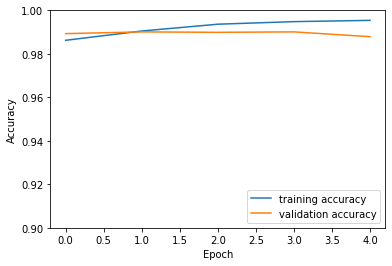

In [19]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

313/313 - 1s - loss: 0.0396 - accuracy: 0.9879


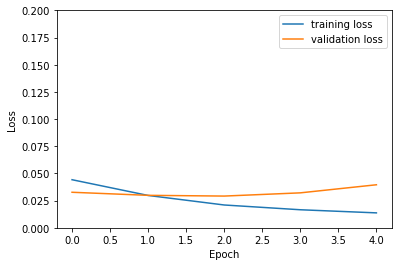

In [20]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.2])
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

In [21]:
y_pred = model.predict(x_test, batch_size=64, 
                               verbose=1)
# y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred_bool))

157/157 [==============================] - 1s 3ms/step


NameError: name 'y_pred_bool' is not defined

# Visualize layers

In [ ]:
layer_1 = model.layers[0]
weights, biases = layer_1.get_weights()

In [ ]:
fig, axes = plt.subplots(4, 8)
for ax, weight in zip(axes.ravel(), weights.T):
    ax.imshow(weight[0, :, :])

# Batch Normalization

Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.


* Deep neural networks are challenging to train, not least because the input from prior layers can change after weight updates.
* Batch normalization is a technique to standardize the inputs to a network, applied to ether the activations of a prior layer or inputs directly.
* Batch normalization accelerates training, in some cases by halving the epochs or better, and provides some regularization, reducing generalization error.

In [24]:
# # Create the convolutional base

# # extra convolutional layer
# from tensorflow.keras.layers import  BatchNormalization


# model_cnn_bn = tf.keras.models.Sequential([
#     Conv2D(32, (3, 3), 
#            activation='relu', 
#            input_shape=(28, 28, 1)),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Conv2D(32, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(10, activation='softmax')    
# ])

# model_cnn_bn.summary()

# # Compile and train the model
# model_cnn_bn.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])


# history_cnn_bn = model_cnn_bn.fit(x=x_train_reshaped, 
#                              y=y_train_encoded, 
#                              epochs=5,
#                              validation_split=0.2)

# model_cnn_bn.evaluate(x_test_reshaped, y_test_encoded)

# y_pred_cnn_bn = model_cnn_bn.predict(x_test_reshaped, batch_size=64, 
#                                verbose=1)
# y_pred_bool_cnn_bn = np.argmax(y_pred_cnn_bn, axis=1)

# print(classification_report(y_test, y_pred_bool_cnn_bn))

# # summarize history for accuracy
# df_result = pd.DataFrame(history_cnn_bn.history)
# df_result[['accuracy', 'val_accuracy']].plot()
# plt.ylabel("accuracy")
# plt.ylim(.9, 1)